In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [80]:
# Preprocessing functions
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

def stem_words(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in text.split()])

# nltk packages
nltk.download('stopwords')
nltk.download('wordnet')

# Data path
data_path = "dataset/*.html"
code2convos = dict()
pbar = tqdm.tqdm(sorted(list(glob(data_path))))

for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")

        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []
        for convo in conversations:
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile(r"[user|assistant]")})
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                text = convo[0].text
                # Implementation of pre-processing steps
                text = clean_text(text)
                text = remove_stopwords(text)
                text = stem_words(text)
                convo_texts.append({
                    "role": role,
                    "text": text
                })

        code2convos[file_code] = convo_texts

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aydint/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aydint/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 127/127 [00:10<00:00, 11.74it/s]


In [81]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'load csv file panda python file name cshwdatasetcsv contain column '
         'like speci island sex diet year life stage bodi mass g bill length '
         'mm bill depth mm flipper length mm health metric'}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [82]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [83]:
prompts[0]

'load csv file panda python file name cshwdatasetcsv contain column like speci island sex diet year life stage bodi mass g bill length mm bill depth mm flipper length mm health metric'

In [85]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset 
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing 
Understanding the Dataset: 
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: 

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data 

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations 

* Correlations of features with health 
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection 
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features 
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters 
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. 
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* 
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen 
- Re-train model with the hyperparameters you have chosen in part 5). 
- Plot the tree you have trained. 
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set 
- Predict the labels of testing data using the tree you have trained in step 6. 
- Report the classification accuracy. 
- Plot & investigate the confusion matrix. Fill the following blanks. 
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split """,
#####################
]


for i in range(len(questions)):
    # Remove leading and trailing spaces
    questions[i] = questions[i].strip()
    
    # Replace multiple spaces with a single space
    questions[i] = re.sub(' +', ' ', questions[i])
    
    # Remove end of line characters
    questions[i] = questions[i].replace('\n', ' ')
    
    # Remove special characters (if any)
    questions[i] = re.sub(r'[^\x00-\x7F]+', '', questions[i])




In [86]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [87]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
##Drop the columns with zero
questions_TF_IDF = questions_TF_IDF.loc[:, (questions_TF_IDF != 0).any(axis=0)]
questions_TF_IDF.head()

,20,80,__,_________,__note,accuracy,all,and,any,are,...,value,values,variable,what,when,why,will,with,you,your
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.089985,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.103373,0.0,0.103373,0.000000,0.352427,0.086479
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.317133,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052674,0.057618,0.111132,...,0.0,0.172855,0.055566,0.0,0.000000,0.0,0.000000,0.105348,0.309445,0.000000
3,0.168964,0.168964,0.000000,0.0,0.000000,0.000000,0.000000,0.441242,0.000000,0.000000,...,0.0,0.000000,0.310314,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.282701
4,0.000000,0.000000,0.080126,0.0,0.080126,0.073578,0.080126,0.139497,0.076296,0.073578,...,0.0,0.000000,0.147156,0.0,0.000000,0.0,0.000000,0.209245,0.068292,0.134062


In [88]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [89]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

for code, df in code2prompts_tf_idf.items():
    # Find columns with all zero values
    zero_columns = df.columns[(df == 0).all(axis=0)]
    
    # Remove these columns
    df.drop(zero_columns, axis=1, inplace=True)
    
    # Save updated DataFrame back to dictionary
    code2prompts_tf_idf[code] = df



In [96]:


feature_means = questions_TF_IDF.mean(axis=0)

overall_mean = feature_means.mean()

# Calculate the absolute difference of each feature to the grand average
feature_diffs = np.abs(feature_means - overall_mean)

# Sort the features based on these differences and select the 5 closest features
closest_features = feature_diffs.nsmallest(5).index

# Extract selected features
X_reduced = questions_TF_IDF.drop(columns=closest_features)

code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 464)

In [100]:
# Get all column names
all_columns = questions_TF_IDF.columns

# Update TF-IDF matrices for each user
updated_code2prompts_tf_idf = {}
for code, df in code2prompts_tf_idf.items():
    # Fill missing columns with zero values and rearrange columns
    missing_cols = [col for col in all_columns if col not in df.columns]
    missing_data = pd.DataFrame(0, index=np.arange(len(df)), columns=missing_cols)
    df = pd.concat([df, missing_data], axis=1)
    df = df[all_columns]
    updated_code2prompts_tf_idf[code] = df


code2cosine = dict()
for code, user_prompts_tf_idf in updated_code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF, user_prompts_tf_idf))


In [101]:
questions[4]

"Features and Correlations   * Correlations of features with health  Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.  * Feature Selection  Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.  * Hypothetical Driver Features  Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.  * __Note:__ You get can get help from GPT."

In [102]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.095215,0.310113,0.181659,0.139208,0.098872,0.124660,0.047261,0.066672,0.137822
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.089105,0.345151,0.218900,0.184695,0.108674,0.202008,0.206330,0.144328,0.339487
2,041f950b-c013-409a-a642-cffff60b9d4b,0.032381,0.095378,0.136368,0.064370,0.101562,0.054635,0.122744,0.117816,0.093157
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.040570,0.120144,0.120217,0.134553,0.082192,0.150722,0.084742,0.095720,0.279134
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.182656,0.288943,0.216272,0.136995,0.113740,0.166940,0.149825,0.200704,0.315899
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.072408,0.138691,0.120217,0.129012,0.098952,0.137335,0.238542,0.210948,0.347616
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.085822,0.120144,0.120217,0.184695,0.147032,0.202008,0.130179,0.200704,0.339487
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.101504,0.415000,0.240781,0.190228,0.155578,0.199936,0.232485,0.208360,0.339487
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.068663,0.415000,0.240781,0.155235,0.155578,0.186212,0.238542,0.208360,0.352977


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [103]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [104]:
from textblob import TextBlob  # For sensitivity analysis

for code, convs in code2convos.items():
    if len(convs) == 0:
        continue

    total_user_prompts = 0
    total_responses = 0
    total_user_sentiment = 0
    total_response_sentiment = 0

    for c in convs:
        text = c["text"].lower()
        sentiment = TextBlob(text).sentiment.polarity  # Calculate the sentiment score of the text

        if c["role"] == "user":
            # User Prompts
            total_user_prompts += 1
            total_user_sentiment += sentiment
            # ... (current user input operations)
        else:
            # ChatGPT Responses
            total_responses += 1
            total_response_sentiment += sentiment
            # ... (current ChatGPT response operations)

    # Calculate average sentiment scores
    code2features[code]["avg_user_sentiment"] = total_user_sentiment / total_user_prompts if total_user_prompts > 0 else 0
    code2features[code]["avg_response_sentiment"] = total_response_sentiment / total_responses if total_responses > 0 else 0

   


In [105]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,avg_response_sentiment
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,0.0,0.0,0.0,0.0,1.483585,144.506510,-0.055934,0.041880
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.140003,69.970834,0.151852,0.011192
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,0.152700,9.357490,0.041152,0.113040
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,0.0,0.0,0.0,0.0,0.068027,71.168689,0.024792,0.050422
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,0.0,0.0,0.0,0.0,0.009872,11.652469,0.106032,0.119472


In [106]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


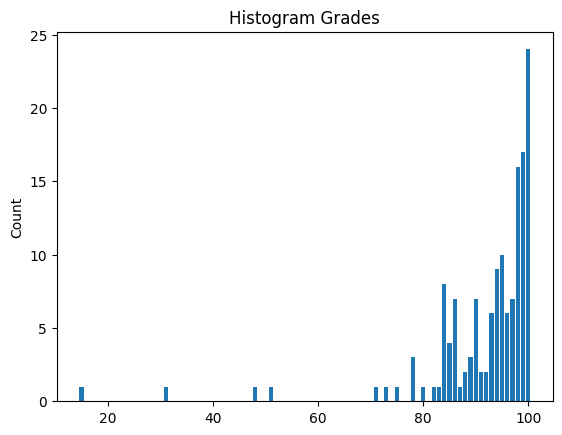

In [107]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [108]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,avg_response_sentiment
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,0.0,0.0,0.0,0.0,1.483585,144.506510,-0.055934,0.041880
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.140003,69.970834,0.151852,0.011192
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,0.152700,9.357490,0.041152,0.113040
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,0.0,0.0,0.0,0.0,0.068027,71.168689,0.024792,0.050422
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,0.0,0.0,0.0,0.0,0.009872,11.652469,0.106032,0.119472


In [109]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,avg_response_sentiment,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,0.0,0.0,0.0,0.0,1.483585,144.506510,-0.055934,0.041880,0.095215,0.310113,0.181659,0.139208,0.098872,0.124660,0.047261,0.066672,0.137822
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.140003,69.970834,0.151852,0.011192,0.089105,0.345151,0.218900,0.184695,0.108674,0.202008,0.206330,0.144328,0.339487
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,0.152700,9.357490,0.041152,0.113040,0.032381,0.095378,0.136368,0.064370,0.101562,0.054635,0.122744,0.117816,0.093157
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,0.0,0.0,0.0,0.0,0.068027,71.168689,0.024792,0.050422,0.040570,0.120144,0.120217,0.134553,0.082192,0.150722,0.084742,0.095720,0.279134
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,0.0,0.0,0.0,0.0,0.009872,11.652469,0.106032,0.119472,0.182656,0.288943,0.216272,0.136995,0.113740,0.166940,0.149825,0.200704,0.315899


#### Merging scores with features

In [110]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,avg_user_sentiment,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,0.0,0.0,0.0,0.0,1.483585,144.506510,-0.055934,...,0.095215,0.310113,0.181659,0.139208,0.098872,0.124660,0.047261,0.066672,0.137822,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,0.0,0.140003,69.970834,0.151852,...,0.089105,0.345151,0.218900,0.184695,0.108674,0.202008,0.206330,0.144328,0.339487,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,0.0,0.152700,9.357490,0.041152,...,0.032381,0.095378,0.136368,0.064370,0.101562,0.054635,0.122744,0.117816,0.093157,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,0.0,0.0,0.0,0.0,0.068027,71.168689,0.024792,...,0.040570,0.120144,0.120217,0.134553,0.082192,0.150722,0.084742,0.095720,0.279134,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,0.0,0.0,0.0,0.0,0.009872,11.652469,0.106032,...,0.182656,0.288943,0.216272,0.136995,0.113740,0.166940,0.149825,0.200704,0.315899,100.0


In [111]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 19) (122,)


#### Train/Test split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [113]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [114]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 149.02777777777737
Node 4 has MSE 83.66089965397896
Node 5 has MSE 20.555555555556566
Node 6 has MSE 1.0
Node 7 has MSE 0.0
Node 8 has MSE 0.0
Node 9 has MSE 0.25
Node 10 has MSE 0.0
Node 11 has MSE 0.0
Node 12 has MSE 66.74380165289313
Node 13 has MSE 37.63265306122503
Node 14 has MSE 9.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 10.639999999999418
Node 18 has MSE 1.0
Node 19 has MSE 0.0
Node 20 has MSE 0.0
Node 21 has MSE 2.66666666666697
Node 22 has MSE 0.0
Node 23 has MSE 1.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 17.6875
Node 27 has MSE 6.25
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 1.0
Node 31 has MSE 0.0
Node 32 has MSE 0.0
Node 33 has MSE 0.0
Node 34 has MSE 27.676592797784906
Node 35 has MSE 25.177501826150547
Node 36 has MSE 22.65721450617457
Node 37 has MSE 9.555555555556566
Node 38 has MSE 0.25
Node 39 has MSE 0.0
N

In [69]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [115]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 4.3441479684657365
MSE TEST: 140.77008938869668
R2 Train: 0.9734173364875801
R2 TEST: -0.2539022584718442


In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.svm import SVR

In [117]:
# Parameter ranges for RandomForest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Parameter ranges for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Parameter ranges for SVR
svr_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Creating the models and training
# RandomForest
rf_regressor = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5)
rf_regressor.fit(X_train, y_train)

# XGBoost
xgb_regressor = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=5)
xgb_regressor.fit(X_train, y_train)

# SVR
svr_regressor = GridSearchCV(SVR(), svr_params, cv=5)
svr_regressor.fit(X_train, y_train)

# Printing the best parameters and scores
print("Best RandomForest parameters:", rf_regressor.best_params_)
print("Best RandomForest score:", rf_regressor.best_score_)
print("Best XGBoost parameters:", xgb_regressor.best_params_)
print("Best XGBoost score:", xgb_regressor.best_score_)
print("Best SVR parameters:", svr_regressor.best_params_)
print("Best SVR score:", svr_regressor.best_score_)

# Final evaluation on the test set
y_pred_rf = rf_regressor.predict(X_test)
y_pred_xgb = xgb_regressor.predict(X_test)
y_pred_svr = svr_regressor.predict(X_test)

# Computing MSE for both train and test sets
mse_rf_train = mean_squared_error(y_train, rf_regressor.predict(X_train))
mse_rf_test = mean_squared_error(y_test, y_pred_rf)
print("RandomForest MSE on training set:", mse_rf_train)
print("RandomForest MSE on test set:", mse_rf_test)

mse_xgb_train = mean_squared_error(y_train, xgb_regressor.predict(X_train))
mse_xgb_test = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost MSE on training set:", mse_xgb_train)
print("XGBoost MSE on test set:", mse_xgb_test)

mse_svr_train = mean_squared_error(y_train, svr_regressor.predict(X_train))
mse_svr_test = mean_squared_error(y_test, y_pred_svr)
print("SVR MSE on training set:", mse_svr_train)
print("SVR MSE on test set:", mse_svr_test)

Best RandomForest parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}
Best RandomForest score: -0.7010995052989873
Best XGBoost parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost score: -0.46422510247937343
Best SVR parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVR score: -0.09694301886594907
RandomForest MSE on training set: 56.5771253330775
RandomForest MSE on test set: 119.26275011963182
XGBoost MSE on training set: 66.48132991717156
XGBoost MSE on test set: 115.91207246138481
SVR MSE on training set: 174.88712806385635
SVR MSE on test set: 121.05328078618057


In [118]:
# R^2 score calculations
rf_r2_train = r2_score(y_train, rf_regressor.predict(X_train))
rf_r2_test = r2_score(y_test, y_pred_rf)

xgb_r2_train = r2_score(y_train, xgb_regressor.predict(X_train))
xgb_r2_test = r2_score(y_test, y_pred_xgb)

svr_r2_train = r2_score(y_train, svr_regressor.predict(X_train))
svr_r2_test = r2_score(y_test, y_pred_svr)

# Print R^2 scores for training and test sets
print("RandomForest R^2 on training set:", rf_r2_train)
print("RandomForest R^2 on test set:", rf_r2_test)

print("XGBoost R^2 on training set:", xgb_r2_train)
print("XGBoost R^2 on test set:", xgb_r2_test)

print("SVR R^2 on training set:", svr_r2_train)
print("SVR R^2 on test set:", svr_r2_test)

RandomForest R^2 on training set: 0.6537938633429243
RandomForest R^2 on test set: -0.0623267512010075
XGBoost R^2 on training set: 0.5931881612056362
XGBoost R^2 on test set: -0.03248076402196953
SVR R^2 on training set: -0.0701674325372712
SVR R^2 on test set: -0.07827581009837892


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Predictions')

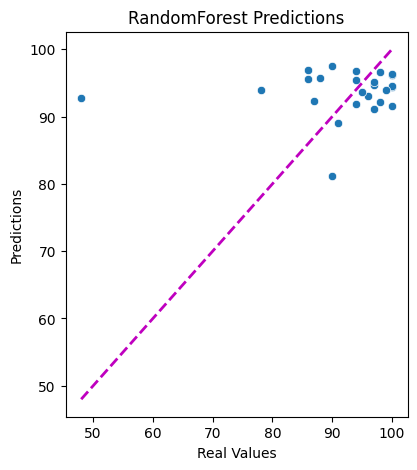

In [120]:
# Display of actual values and predictions side by side
plt.figure(figsize=(15, 5))

# RandomForest predictions
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=2)
plt.title('RandomForest Predictions')
plt.xlabel('Real Values')
plt.ylabel('Predictions')

Text(0, 0.5, 'Predictions')

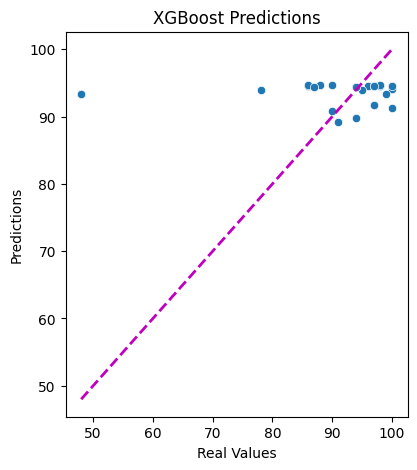

In [121]:
plt.figure(figsize=(15, 5))
#XGBoost predictions
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=2)
plt.title('XGBoost Predictions')
plt.xlabel('Real Values')
plt.ylabel('Predictions')

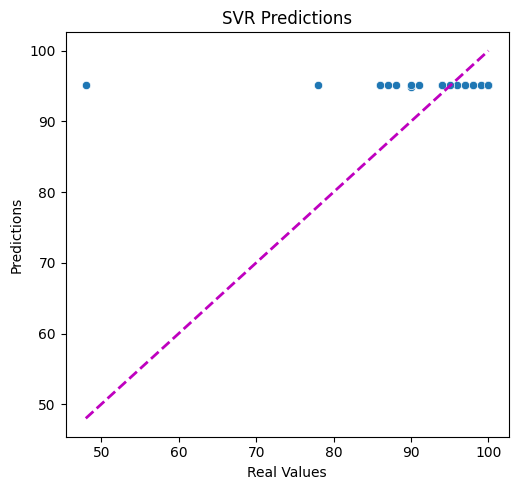

In [122]:
plt.figure(figsize=(15, 5))
# SVR tahminleri
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_svr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=2)
plt.title('SVR Predictions')
plt.xlabel('Real Values')
plt.ylabel('Predictions')

plt.tight_layout()
plt.show()

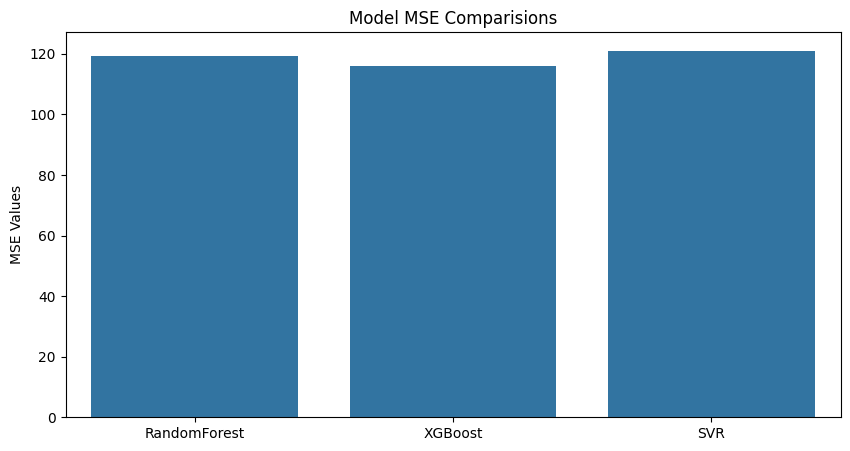

In [123]:
# Model performanslarını bar grafik olarak gösterme
models = ['RandomForest', 'XGBoost', 'SVR']
mses = [mean_squared_error(y_test, y_pred_rf), mean_squared_error(y_test, y_pred_xgb), mean_squared_error(y_test, y_pred_svr)]

plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=mses)
plt.title('Model MSE Comparisions')
plt.ylabel('MSE Values')
plt.show()